<a href="https://colab.research.google.com/drive/1XxI1ZlgVrTL2JBEBXaE05HqUMX8y0dg-?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# HW3 CSC 448

## Abstract

For this project, I have selected the following two datasets:
1. Human Freedom Index 
2. NASA Asteroids Classification

I chose these datasets because I thought they would be a good fit to try some of the learned Regression and Classification techniques on. When I saw the Human Freedom Index dataset, I thought it would be interesting to try and find correlation between different metrics of human freedoms and rights across the world and try to predict them. I also thought it would be interesting to try and understand what makes an asteroid hazardous and how easy it is to predict it.

For classification, I will use two techniques: KNN, and  MLP neural network

Over the course of this networks, I hope to find meaningful insights and correlations in the above datasets and discover trends in the data.

## Section 1: Prepping the Regression datasets

+ For Human Freedom Index, there are multiple columns signifying different levels of persona and economic freedoms, as well as safety that different Countries had over the past decade.

You can read more details on the dataset here: https://www.cato.org/human-freedom-index/2020

In [155]:
# dataset and its first 15 rows
import pandas as pd
import matplotlib.pyplot as plt
freedom_df = pd.read_csv('https://raw.githubusercontent.com/timashana/csc448hw3/main/hfi_cc_2020.csv')

freedom_df.head()


,Unnamed: 0,year,ISO_code,countries,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_injuries,pf_ss_disappearances,pf_ss_women_fgm,pf_ss_women_inheritance,pf_ss_women,pf_ss,pf_movement_domestic,pf_movement_foreign,pf_movement_women,pf_movement,pf_religion_freedom,pf_religion_repression,pf_religion_harassment,pf_religion_restrictions,pf_religion,pf_association_entry,pf_association_assembly,pf_association_barries,pf_association_bans,pf_association_estopparties,pf_association_opposition,pf_association_civilrepression,pf_association,...,ef_money_growth,ef_money_sd,ef_money_inflation,ef_money_currency,ef_money,ef_trade_tariffs_revenue,ef_trade_tariffs_mean,ef_trade_tariffs_sd,ef_trade_tariffs,ef_trade_regulatory_nontariff,ef_trade_regulatory_compliance,ef_trade_regulatory,ef_trade_black,ef_trade_movement_foreign,ef_trade_movement_capital,ef_trade_movement_visit,ef_trade_movement,ef_trade,ef_regulation_credit_ownership,ef_regulation_credit_private,ef_regulation_credit_interest,ef_regulation_credit,ef_regulation_labor_minwage,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank,womens_freedom
0,0,2018,ALB,Albania,Eastern Europe,7.81,43.0,2.0,6.0,4.8,4.3,5.0,9.1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.5,8.8,9.3,10.0,10.0,10.0,10.0,9.0,9.0,9.6,8.0,8.9,8.8,10.0,7.8,8.2,8.0,7.8,8.2,8.6,...,10.0,9.7,9.6,10.0,9.8,9.7,9.3,8.1,9.0,6.8,9.4,8.1,10.0,4.2,4.6,8.3,5.7,8.2,10.0,9.2,10.0,9.7,5.6,4.9,5.6,8.0,6.3,10.0,6.7,5.7,6.7,9.7,5.4,5.6,7.2,6.7,7.7,7.80,26.0,9.26
1,1,2017,ALB,Albania,Eastern Europe,7.78,44.0,2.0,6.3,4.4,4.7,5.3,9.1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.5,8.8,9.3,10.0,10.0,10.0,10.0,8.2,9.0,9.6,8.0,8.7,7.9,10.0,8.0,8.2,8.1,7.9,8.3,8.4,...,9.2,9.7,9.6,10.0,9.6,9.6,9.3,8.1,9.0,6.0,9.4,7.7,10.0,4.2,5.4,8.3,5.9,8.2,10.0,9.1,10.0,9.7,5.6,5.4,6.4,8.0,6.3,10.0,6.9,6.3,6.7,9.7,6.0,6.0,7.2,7.0,7.9,7.70,36.0,9.26
2,2,2016,ALB,Albania,Eastern Europe,7.63,50.0,2.0,6.7,4.5,4.7,5.3,8.6,10.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,7.5,8.7,10.0,10.0,5.0,8.3,9.0,8.9,9.6,8.0,8.9,7.9,10.0,8.0,8.2,8.1,8.0,8.3,8.5,...,9.0,9.5,9.7,10.0,9.6,9.6,9.2,8.0,9.0,5.6,9.4,7.5,10.0,4.2,4.6,8.3,5.7,8.0,10.0,7.3,9.0,8.8,5.6,5.4,6.2,8.0,6.3,10.0,6.9,6.1,6.0,9.7,6.0,7.3,7.1,7.0,7.6,7.69,36.0,7.50
3,3,2015,ALB,Albania,Eastern Europe,7.55,52.0,2.0,6.7,4.5,4.7,5.2,8.9,10.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,7.5,8.8,5.0,10.0,5.0,6.7,9.0,8.9,9.2,8.5,8.9,7.9,10.0,8.0,8.2,8.1,8.0,8.3,8.5,...,9.3,9.4,9.6,10.0,9.6,9.3,9.2,8.0,8.9,5.4,9.4,7.4,10.0,4.2,4.6,8.3,5.7,8.0,10.0,7.6,10.0,9.2,5.6,5.0,6.1,8.0,6.3,10.0,6.8,6.1,6.0,9.7,6.0,7.3,7.1,7.0,7.7,7.70,34.0,7.50
4,4,2014,ALB,Albania,Eastern Europe,7.65,48.0,2.0,6.1,4.8,4.6,5.0,8.4,10.0,10.0,10.0,9.9,9.9,9.9,10.0,5.0,7.5,8.6,5.0,10.0,5.0,6.7,9.0,8.9,9.7,9.9,9.4,7.9,10.0,8.0,8.2,8.1,8.0,8.3,8.5,...,9.4,9.4,9.7,10.0,9.6,9.4,9.2,8.0,8.9,6.3,9.2,7.7,10.0,4.2,4.6,8.3,5.7,8.1,10.0,8.0,10.0,9.3,5.6,6.1,7.2,8.0,6.3,10.0,7.2,5.9,6.0,9.7,6.0,7.2,6.0,6.8,7.8,7.65,37.0,7.50


In [156]:
# more info:
freedom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Columns: 113 entries, Unnamed: 0 to womens_freedom
dtypes: float64(108), int64(2), object(3)
memory usage: 1.5+ MB


In [157]:
# list of columns in the dataset:
list(freedom_df)

['Unnamed: 0',
 'year',
 'ISO_code',
 'countries',
 'region',
 'hf_score',
 'hf_rank',
 'hf_quartile',
 'pf_rol_procedural',
 'pf_rol_civil',
 'pf_rol_criminal',
 'pf_rol',
 'pf_ss_homicide',
 'pf_ss_disappearances_disap',
 'pf_ss_disappearances_violent',
 'pf_ss_disappearances_organized',
 'pf_ss_disappearances_fatalities',
 'pf_ss_disappearances_injuries',
 'pf_ss_disappearances',
 'pf_ss_women_fgm',
 'pf_ss_women_inheritance',
 'pf_ss_women',
 'pf_ss',
 'pf_movement_domestic',
 'pf_movement_foreign',
 'pf_movement_women',
 'pf_movement',
 'pf_religion_freedom',
 'pf_religion_repression',
 'pf_religion_harassment',
 'pf_religion_restrictions',
 'pf_religion',
 'pf_association_entry',
 'pf_association_assembly',
 'pf_association_barries',
 'pf_association_bans',
 'pf_association_estopparties',
 'pf_association_opposition',
 'pf_association_civilrepression',
 'pf_association',
 'pf_expression_killed',
 'pf_expression_jailed',
 'pf_expression_media',
 'pf_expression_cable',
 'pf_express

There are multiple interestingfeatures in this dataset. As a woman, I am personally interested in women's issues. This is the feature I will be trying to predict.

+ **pf_ss_women** - This measures the security and safety of women in a given country in a given year


For now, I am not sure what features I will use for predicting this value - I will decide that after some further data exploration.

For now, I will proceed with data cleaning.
    

In [159]:
# Get rid of columns that have more than 10% values missing
lim = len(freedom_df) * .9
freedom_df.dropna(thresh = lim, axis = 1, inplace=True)
# After that, get rid of all invalid entries
#  I do not want to populate missing entries with mean/median, since it might affect the model's accuracy
#  Since there is planty of entries in the dataset, I chose to get rid of invalid once and then check for the damage
freedom_df.dropna(axis = 0, inplace = True)

# Chack the damage - not bad!:
freedom_df.shape

(1134, 100)

In [161]:
# make sure the target column was not deleted:
print('Yay!' if 'pf_ss_women' in list(freedom_df) else 'Nay :(')

Yay!


Good, Let's move on.

## Section 2: Linear Regression

First, we want to look at the correlation between pf_ss_women and other features in the dataset to find potential predictors.

In [162]:
# Sort and display values with strong correlation to womens' safety:

target_col = 'pf_ss_women'

freedom_corr = freedom_df.corr()[target_col].sort_values()
freedom_corr = freedom_corr[abs(freedom_corr) > 0.4]
freedom_corr


pf_rank                              -0.681282
hf_rank                              -0.678271
hf_quartile                          -0.643561
ef_rank                              -0.548114
ef_government_transfers              -0.463612
ef_money                              0.406654
pf_religion                           0.406987
ef_trade_movement_foreign             0.410635
pf_association_civilrepression        0.415263
ef_regulation_credit                  0.438309
ef_regulation_business_bribes         0.439999
pf_association                        0.441248
pf_expression                         0.443525
ef_government_soa                     0.454744
ef_government_enterprises             0.458849
pf_religion_repression                0.460443
pf_association_opposition             0.464427
pf_expression_media                   0.466314
ef_legal_military                     0.486056
ef_trade                              0.489164
pf_movement                           0.489996
ef_trade_regu

After first glance at the above correlations, it seems to me like freedom of religion, religious prosecution and harrasment, and restrictions might be a good predictor of women's safety.

+ My hypothesis is that in countries with stricter religious rules, women might be less safe.

Beforehand, I checked for multicollinearity between the following four features:
1. pf_religion
2. pf_religion_repression
3. pf_religion_harassment
4. pf_religion_restrictions

Turned out, they were pairwise linearly dependent, so I only needed pairs of 1-3 or 2-4 to predict pf_ss_women. Since pf_religion_repression had high correlation with pf_ss_women, it was a pair of choise. 

However, after checking for linearity between that pair and pf_ss_women, the scatter plot for pf_religion_restrictions did not seem linear in the slightest (see below).

**TLDR: I ended up choosing a single predictor for pf_ss_women, namely pf_religion_repression**


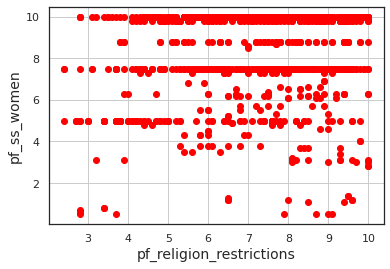

In [164]:

# Check for linearity of the independent variables vs the dependent one (pf_ss_women):
# independent:
# pf_religion - not really linear,
# pf_religion_freedom - so so,
# pf_religion_repression - so so,
# pf_religion_harassment - so so,
# pf_religion_restrictions - not linear
# dependent:
# pf_ss_women
# codependency:
# pf_religion_freedom vs pf_religion_repression - almost 1-to-1
# pf_religion_freedom vs pf_religion_harassment - more diverse
# pf_religion_freedom vs pf_religion_restrictions - more diverse
# pf_religion_repression vs pf_religion_harassment - a ok for low values, converges at higher values
# pf_religion_repression vs pf_religion_restrictions - same as above
# pf_religion_harassment vs pf_religion_restrictions - almost 1-to-1
# pf_religion_repression vs pf_ss_women

independent = 'pf_religion_restrictions'
target_col = 'pf_ss_women'
plt.scatter(freedom_df[independ], freedom_df[target_col], color='red')
plt.xlabel(independent, fontsize=14)
plt.ylabel(target_col, fontsize=14)
plt.grid(True)
plt.show()

In [165]:
# Here is feature extraction using Pandas:
X = freedom_df[['pf_religion_repression']]
y = freedom_df[['pf_ss_women']]

Nice and then we use sklearn to create a training set and test set. I will reserve 20% of the dataset for testing.

In [166]:
# Use sklearn to split our dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=101)

Let's use that training set and fit a Linear Regression to it:

In [167]:
# Use sklearn to create and Linear Regressor and fit our data to it
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To make sure we're on the right track let's try a couple made up sample inputs and see what our model returns:

In [168]:
# experiment with the regressor
lm.predict([[0.2],[0.5]])

array([[5.21702886],
       [5.34683099]])

We all love data visualizations so let's create a plot of our linear regression and our data. I will have the training data be blue dots, the test data green dots, with a red regression line cutting through the data.

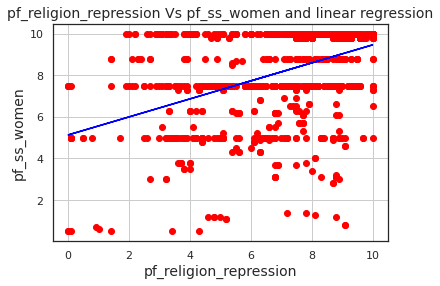

In [169]:
# Use matplotlib (or other visualization lib) to create a scatter plot and the regression to create a regression line

# plots
plt.scatter(freedom_df['pf_religion_repression'], freedom_df['pf_ss_women'], color='red')
plt.plot(X, lm.predict(X), color='blue')
plt.title('pf_religion_repression Vs pf_ss_women and linear regression', fontsize=14)
plt.xlabel('pf_religion_repression', fontsize=14)
plt.ylabel('pf_ss_women', fontsize=14)
plt.grid(True)
plt.show()

In [172]:
# Use linear regression model to report accuracy/error rate on the test set
lm.score(X_test, y_test)

0.2192914692472947

Good not great. 

Looking at the scatter plot again, maybe the data is not that linear after all.

**My second hypothesis was to predict women's safety based on how much personal freedom they enjoy.**

In [174]:
# this time I will try to predict women's safety and security based on women's freedom:
X = freedom_df[['womens_freedom']]
y = freedom_df[['pf_ss_women']]


In [175]:
# divide the dataset and fit the regressor:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=99)
lm = LinearRegression()
lm.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [178]:
# this time the score is much better:
lm.score(X_test, y_test)

0.8406417328988989

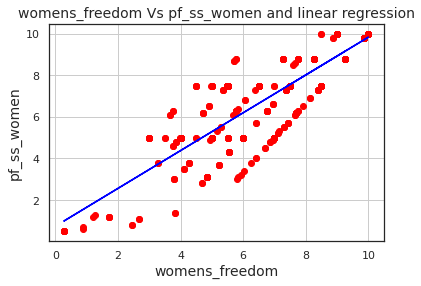

In [179]:
# plots
plt.scatter(freedom_df['womens_freedom'], freedom_df['pf_ss_women'], color='red')
plt.plot(X, lm.predict(X), color='blue')
plt.title('womens_freedom Vs pf_ss_women and linear regression', fontsize=14)
plt.xlabel('womens_freedom', fontsize=14)
plt.ylabel('pf_ss_women', fontsize=14)
plt.grid(True)
plt.show()


In [180]:
# Cross validation

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

scores = cross_val_score(lm, X, y, cv=6)
print('Cross-validated scores:', scores)

Cross-validated scores: [0.71294903 0.93933435 0.85254449 0.76626196 0.82908834 0.77958356]


Based on the results, my second hypothesis turned out to be much more accurate.
It makes sense that in the countries with more freedom for women, they are generally safer.

## Section 3: Prepping the classification dataset

+ In this section, I will try to classify NASA-observed asteroids as hazardous or non-hazardous.

In [181]:
nasa_df = pd.read_csv('https://raw.githubusercontent.com/timashana/csc448hw3/main/nasa.csv')

nasa_df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [185]:
nasa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

From the info above, it looks like all data is clean!

In [187]:
# Use pandas to map Hazardous Boolean category to ints
nasa_df.Hazardous = nasa_df.Hazardous.astype(int)
nasa_df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,1
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,0
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,1
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,0
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,1


Here's a summary of the data mapping:

0 = Non-Hazardous

1 = Hazardous


## Section 4: Classification with a Neural Network (or classifier of choice)

In this section I'm going to find 3 best features and use them to predict if an asteroid is hazardous.

Once again let's split out our data into a training and test set. I will hold 20% of the data for testing.

In [188]:
# see correlation:
nasa_df.corr()['Hazardous']
target_col = 'Hazardous'

nasa_corr = nasa_df.corr()[target_col].sort_values()
nasa_corr = nasa_corr[abs(nasa_corr) > 0.1]
nasa_corr

Orbit Uncertainity             -0.328721
Absolute Magnitude             -0.325522
Minimum Orbit Intersection     -0.288949
Neo Reference ID               -0.269028
Name                           -0.269028
Perihelion Distance            -0.207027
Est Dia in Miles(min)           0.132424
Est Dia in KM(min)              0.132424
Est Dia in KM(max)              0.132424
Est Dia in M(max)               0.132424
Est Dia in Feet(max)            0.132424
Est Dia in M(min)               0.132424
Est Dia in Feet(min)            0.132424
Est Dia in Miles(max)           0.132424
Eccentricity                    0.183269
Relative Velocity km per hr     0.191970
Miles per hour                  0.191970
Relative Velocity km per sec    0.191970
Orbit ID                        0.247369
Hazardous                       1.000000
Name: Hazardous, dtype: float64

In [189]:
# Use sklearn to split our dataset

X = nasa_df[['Orbit Uncertainity', 'Absolute Magnitude', 'Minimum Orbit Intersection']]
y = nasa_df['Hazardous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=101)

In [190]:
# KNN with 3 neigbors:

from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

y_hat = neighbors.predict(X_test)

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neighbors.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_hat))


Train set Accuracy:  0.9573105656350054
Test set Accuracy:  0.8936


**Looks like KNN with 3 neighbours yielded good results!**

However, let's also look at a Multi-Layer Perceptron.

In [192]:
# Use sklearn to scale the feature vector

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [193]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

For this project I will use a neural network with 3 hidden layers with 3 nodes per layer. The input size will be 3 (1 per attribute) and the output will be 1 (since there are 8 breeds of cat).

In [194]:
# Initialize a MLP Classifier with your choice of parameters
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(3,3,3))

In [195]:
# Fit the network, print the trained weights, and try sample data`
mlp.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 3, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Once again let's analyze the accuracy of our machine learning. Here is the accuracy for the test set.

In [196]:
# Report on the accuracy of the Test set for your classifier
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3149    0]
 [ 601    0]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3149
           1       0.00      0.00      0.00       601

    accuracy                           0.84      3750
   macro avg       0.42      0.50      0.46      3750
weighted avg       0.71      0.84      0.77      3750



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


And just as before let's do a k-fold cross validation to see if we didn't just get lucky (or unlucky on our first go).

In [197]:
# Cross validation

scores = cross_val_score(mlp, X, y, cv=6)
print('Cross-validated scores:', scores)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross-validated scores: [0.83887468 0.92445583 0.83866837 0.83866837 0.83866837 0.93854033]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Conclusions


In the aftermath, in the course of this project, I found that for Linear Regression, it is important to use highly-correlated data that is linear. For that, it helps to first look at the correlation matrix, and then look at the scatter plots of the features of interest to find good predictors.

For classification, depending on the data, it seems like there were diferent levels of complexity models that can produce good results. It also helped a lot to look at the correlation series between the target value and the other features to find goos predictors.

If I had more time, I would have enjoyed visualizing the neural network - seems like a fun project. I would also try other models to see how differently they would've performed.